In [180]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import Counter
import random
import math

In [14]:
inputString = '''
1 1 1
1 6 1
2 1 2
3 9 2
3 10 2
4 6 1
5 6 2
7 2 2
8 1 1
8 9 1
9 1 1
9 9 1
9 10 2
10 3 1
10 5 2
'''
dataFromStr = [[int(e) for e in textline.split(' ')] for textline in inputString.strip().split('\n')]

In [354]:
dataFromStr

[[1, 1, 1],
 [1, 6, 1],
 [2, 1, 2],
 [3, 9, 2],
 [3, 10, 2],
 [4, 6, 1],
 [5, 6, 2],
 [7, 2, 2],
 [8, 1, 1],
 [8, 9, 1],
 [9, 1, 1],
 [9, 9, 1],
 [9, 10, 2],
 [10, 3, 1],
 [10, 5, 2]]

In [361]:
E1 = [tuple(row[:-1]) for row in dataFromStr if row[2]==1]
E2 = [tuple(row[:-1]) for row in dataFromStr if row[2]==2]
print(E1)
print(E2)

[(1, 1), (1, 6), (4, 6), (8, 1), (8, 9), (9, 1), (9, 9), (10, 3)]
[(2, 1), (3, 9), (3, 10), (5, 6), (7, 2), (9, 10), (10, 5)]


In [29]:
inputString = '''
1 1 
1 6 
2 1 
3 9 
3 10
4 6 
5 6 
7 2 
8 1 
8 9 
9 1 
9 9 
9 10 
10 3 
10 5 
'''
dataFromStrNoClass = [[int(e) for e in textline.strip().split(' ')] for textline in inputString.strip().split('\n')]

In [313]:
dataFromStrNoClass

[[1, 1],
 [1, 6],
 [2, 1],
 [3, 9],
 [3, 10],
 [4, 6],
 [5, 6],
 [7, 2],
 [8, 1],
 [8, 9],
 [9, 1],
 [9, 9],
 [9, 10],
 [10, 3],
 [10, 5]]

In [15]:
df = pd.DataFrame(
    data=dataFromStr,
    columns=['x','y','label']
)

In [16]:
df

,x,y,label
0,1,1,1
1,1,6,1
2,2,1,2
3,3,9,2
4,3,10,2
5,4,6,1
6,5,6,2
7,7,2,2
8,8,1,1
9,8,9,1


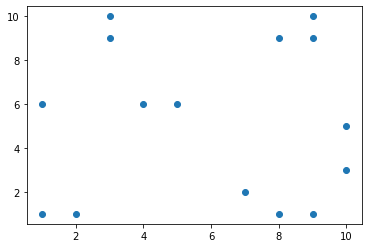

In [25]:
fig, ax = plt.subplots(1,1)

# ax.scatter(x=df['x'], y=df['y'])

ax.scatter(df['x'], df['y'])


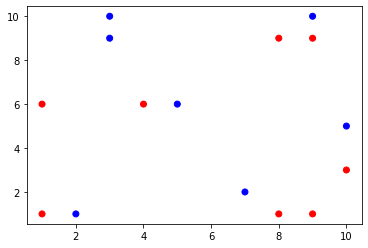

In [23]:
fig, ax = plt.subplots(1,1)

colors = {1: 'red', 2: 'blue'}

# ax.scatter(x=df['x'], y=df['y'])

ax.scatter(df['x'], df['y'], c=df['label'].map(colors))

In [314]:
def get_initial_means(array, k=2, method='rand'):
    """
    Picks k random points from the 2D array 
    (without replacement) to use as initial 
    cluster means

    params:
    array = numpy.ndarray[numpy.ndarray[float]] - m x n | datapoints x features

    k = int

    returns:
    initial_means = numpy.ndarray[numpy.ndarray[float]]
    """
    # TODO: finish this function
    if method != 'rand':
        e1_points = df[df['label']==1]
        e2_points = df[df['label']==2]

        e1_xMean = e1_points['x'].mean()
        e1_yMean = e1_points['y'].mean()

        e2_xMean = e2_points['x'].mean()
        e2_yMean = e2_points['y'].mean()

        meanOfE1 = (e1_xMean, e1_yMean)
        meanOfE2 = (e2_xMean, e2_yMean)
        ret = [
            meanOfE1,
            meanOfE2
        ]
    else:
        # ret = [
            # [random.randint(1,10),random.randint(1,10)], # x,y of point 1
            # [random.randint(1,10),random.randint(1,10)],
            # [random.randint(1,10),random.randint(1,10)],
        # ]
        ret = random.sample(array, k=3)
    return np.array(ret)



In [316]:
initMeans = get_initial_means(dataFromStrNoClass)
initMeans

array([[9, 9],
       [8, 1],
       [4, 6]])

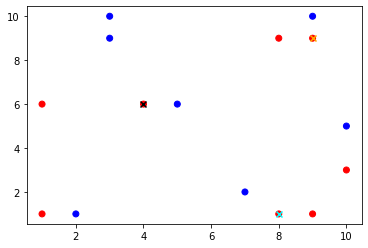

In [317]:
fig, ax = plt.subplots(1,1)

colors = {1: 'red', 2: 'blue'}

ax.scatter(df['x'], df['y'], c=df['label'].map(colors))
ax.scatter([initMeans[0][0]], [initMeans[0][1]], marker='x',c='orange')
ax.scatter([initMeans[1][0]], [initMeans[1][1]], marker='x',c='cyan')
ax.scatter([initMeans[2][0]], [initMeans[2][1]], marker='x',c='black')

In [338]:
def k_means_step(X, k, means, DEBUG=False):
    """
    A single update/step of the K-means algorithm
    Based on a input X and current mean estimate,
    predict clusters for each of the pixels and 
    calculate new means. 
    params:
    X = numpy.ndarray[numpy.ndarray[float]] - m x n | pixels x features (already flattened)
        (15,2)
    k = int
    means = numpy.ndarray[numpy.ndarray[float]] - k x n
        (2,2)

    returns:
    (new_means, clusters)
    new_means = numpy.ndarray[numpy.ndarray[float]] - k x n
    clusters = numpy.ndarray[int] - m sized vector
    """
    dataset = X

    # Step 2
    pointToCluster = {} # x,y point example from dataset -> cluster label
    for point in dataset:
        dists = [(np.linalg.norm(point-means[i]), i) for i in range(k)]
        bestDist = min(dists)
        closestClusterLabel = bestDist[1]
        pointToCluster[tuple(point.tolist())] = closestClusterLabel
    
    if DEBUG:
        print('====== BEGIN K_M STEP ======')
        print('clusters:', c)
        print('---')
        print(pointToCluster)
        print('\n')
    
    # Step 3: Covar Mtx for each Cluster
    covMatricies = {} # clusterLabel -> cov
    clusterSizes = {} # clusterLabel -> cluster size
    clusterLabels = set(pointToCluster.values())
    for clusterLabel in clusterLabels: # 1,2,3
        points = {
            point:label
            for point, label in pointToCluster.items()
            if label == clusterLabel
        }
        print('points for cluster', clusterLabel, points)
        listOfThisClustersPoints = list(points.keys())

        x_values, y_values = zip(*listOfThisClustersPoints)
        covdata = np.vstack((x_values, y_values))
        thisClustersCOV = np.cov(covdata)
        
        covMatricies[clusterLabel] = thisClustersCOV
        clusterSizes[clusterLabel] = len(listOfThisClustersPoints)
    # end for each cluster, get COV
    
    if DEBUG:
        print('-'*15)
        print('covMatricies')
        for label,cov in covMatricies.items():
            print('covar matrix',label)
            print(cov)
        print('clusterSizes')
        print(clusterSizes)
        print('-'*15)
        print('inverse COV matrices')
    
    # Step 4 Setup: Calculate required inv-cov-mtx's and Cluster Means
    inverseCOVs = {}
    for clusterLabel,cov in covMatricies.items():
        inv = np.linalg.inv(cov)
        inverseCOVs[clusterLabel] = inv * -1
        if DEBUG:
            print(clusterLabel)
            print(inverseCOVs[clusterLabel])
            print(clusterLabel)
    
    if DEBUG:
        print('-'*15)
        print('Cluster Means')
    clusterMeans = {} # clusterLabel -> [x_mean, y_mean]
    for clusterLabel in clusterLabels:
        clusterPoints = [point for point,cluster in pointToCluster.items() if cluster==clusterLabel]
        clusterMean = np.mean(clusterPoints, axis=0)
        clusterMeans[clusterLabel] = clusterMean
        if DEBUG:
            print('\nCluster', clusterLabel)
            print('Points',clusterPoints)
            print('XY Mean',clusterMean)
    if DEBUG:
        print('-'*15)
        print()
    
    def mahaDist(point, clusterLabel, DEBUG=True):
        meanDiff = point - clusterMeans[clusterLabel] # v-m
        
        tempMtx = np.matmul(meanDiff, covMatricies[clusterLabel])
        
        sqDist = np.matmul(tempMtx, np.transpose(tempMtx))
        
        finalMHdist = math.sqrt(sqDist)
        if DEBUG:
            print(f'Mahalanobis Dist for {point} to cluster {clusterLabel}')
            print('Mean Difference')
            print(meanDiff)
            print('*')
            print('Inverse Cov Matrix')
            print(covMatricies[clusterLabel])
            print('temp Matrix')
            print(tempMtx)
            print('square distance')
            print(sqDist)
            print('final MH dist')
            print(finalMHdist,'\n')
        return finalMHdist
    
    # Step 4 & 5: For each point, calculate MD dist to each cluster
    #             Then, assign to min-dist cluster label
    pointToCluster = {} # x,y point example from dataset -> cluster label
    for point in dataset:  
        dists = [
            (mahaDist(point, clusterLabel), clusterLabel)
            for clusterLabel in clusterLabels
        ]
        bestDist = min(dists)
        closestClusterLabel = bestDist[1]
        pointToCluster[tuple(point.tolist())] = closestClusterLabel
        if DEBUG:
            print(f'Point {point} To Cluster Distances:', dists)
    
    if DEBUG:
        print('final pointToCluster')
        print(pointToCluster)
    curClusters = [
        [point for point,label in pointToCluster.items() if label==clusterLabel]
        for clusterLabel in clusterLabels
    ]
#     print( list(clusterMeans.values()) )
#     print(curClusters)
    
    return list(clusterMeans.values()), curClusters

IndentationError: expected an indented block (3557093646.py, line 130)

In [259]:
k_means_step(np.array(dataFromStrNoClass), k=3, means=initMeans, DEBUG=True)

[array([8.83333333, 3.5       ]), array([4.8, 8.8]), array([3. , 3.5])]
[[(4, 6), (9, 9), (10, 3), (10, 5)], [(3, 9), (3, 10), (5, 6), (8, 9), (9, 10)], [(1, 1), (1, 6), (2, 1), (7, 2), (8, 1), (9, 1)]]


([array([8.83333333, 3.5       ]), array([4.8, 8.8]), array([3. , 3.5])],
 [[(4, 6), (9, 9), (10, 3), (10, 5)],
  [(3, 9), (3, 10), (5, 6), (8, 9), (9, 10)],
  [(1, 1), (1, 6), (2, 1), (7, 2), (8, 1), (9, 1)]])

In [358]:
def vizIter(curMeans, clusterData):
    fig, ax = plt.subplots(1,1)
    colors = ['red','blue','green']
    for i,clusterXYs in enumerate(clusterData):
        xy = clusterXYs[0]
        print(xy, type(xy))
        xValues_e1 = [xy[0] for xy in clusterXYs if xy in E1]
        yValues_e1 = [xy[1] for xy in clusterXYs if xy in E1]
        ax.scatter(xValues_e1, yValues_e1, marker='P', c=colors[i])
        
        xValues_e2 = [xy[0] for xy in clusterXYs if xy in E2]
        yValues_e2 = [xy[1] for xy in clusterXYs if xy in E2]
        ax.scatter(xValues_e2, yValues_e2, marker='+', c=colors[i])
        
        thisMean = curMeans[i]
        ax.scatter([thisMean[0]], [thisMean[1]], marker='x', c=colors[i])
    plt.show()
    return

In [347]:
def k_means_segment(dataset, k=2, initial_means=None, DEBUG=False):
    """
    Separate the provided RGB values into
    k separate clusters using the k-means algorithm,
    then return an updated version of the image
    with the original values replaced with
    the corresponding cluster values.

    params:
    image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - r x c x ch
    k = int
    initial_means = numpy.ndarray[numpy.ndarray[float]] or None

    returns:
    updated_image_values = numpy.ndarray[numpy.ndarray[numpy.ndarray[float]]] - r x c x ch
    """
    if initial_means is None:
        print('creating initial means...')
        initial_means = get_initial_means(dataset, k)
    
    if DEBUG:
        print('init means')
        print(initial_means)
        print('-'*15)

    print('1st call to k_means')
    curMeans, curClusters = k_means_step(dataset, k, initial_means, DEBUG=True)
    vizIter(curMeans, curClusters)
    if DEBUG:
        print('curMeans')
        print(curMeans)
        print('curClusters')
        print(curClusters)
        print()
    
    iterStyle = 2
    if iterStyle == 2:
        print('2nd call to k_means')
        curMeans, curClusters = k_means_step(dataset, k, curMeans, DEBUG=True)
        vizIter(curMeans, curClusters)
        prevClusters = tuple([tuple(c) for c in curClusters])
    else:
        prevClusters = tuple([tuple(c) for c in curClusters])
        for i in range(10):
            curMeans, curClusters = k_means_step(dataset, k, curMeans, DEBUG=True)
            vizIter(curMeans, curClusters)
            if prevClusters == tuple([tuple(c) for c in curClusters]):
                break
            prevClusters = tuple([tuple(c) for c in curClusters])
    
    if DEBUG:
        print('====== END K_M STEPPING ======')
        print('curMeans')
        print(curMeans)
        print('curClusters')
        print(curClusters)
    
    return curMeans, prevClusters
    '''
    updated_image_values = np.zeros(image_values.shape) # (233, 502, 3)
    for i in range(len(image_values)): # i in 0...233
        for j in range(len(image_values[i])): # j in 0...502
            # updated_image_values[i][j] = np.array( [curClusters[i][j]] )
            updated_image_values[i][j] = curMeans[curClusters[i][j]]
    '''
#     index_array = curClusters.ravel()
    # Use index_array to index into curMeans and reshape the result to the shape of image_values
#     updated_dataset = curMeans[index_array].reshape(dataset.shape)
    
#     return updated_dataset

In [348]:
initMeans = [
    (2, 1),
    (7, 2),
    (9, 10)
]

In [352]:
initMeans = get_initial_means(dataFromStrNoClass)
print(initMeans)

[[ 1  1]
 [ 3  9]
 [ 9 10]]


[[ 1  1]
 [ 3  9]
 [ 9 10]]
init means
[[ 1  1]
 [ 3  9]
 [ 9 10]]
---------------
1st call to k_means
====== BEGIN K_M STEP ======
clusters: Counter({0: 5, 1: 5, 2: 5})
---
{(1, 1): 0, (1, 6): 1, (2, 1): 0, (3, 9): 1, (3, 10): 1, (4, 6): 1, (5, 6): 1, (7, 2): 0, (8, 1): 0, (8, 9): 2, (9, 1): 0, (9, 9): 2, (9, 10): 2, (10, 3): 2, (10, 5): 2}


---------------
covMatricies
covar matrix 0
[[13.3  0.4]
 [ 0.4  0.2]]
covar matrix 1
[[ 2.2  -0.35]
 [-0.35  3.8 ]]
covar matrix 2
[[ 0.7  -2.05]
 [-2.05  9.2 ]]
---------------
inverse COV matrices
0
[[-0.08  0.16]
 [ 0.16 -5.32]]
0
1
[[-0.46130501 -0.04248862]
 [-0.04248862 -0.26707132]]
1
2
[[-4.11173184 -0.91620112]
 [-0.91620112 -0.31284916]]
2
---------------
Cluster Means

Cluster 0
Points [(1, 1), (2, 1), (7, 2), (8, 1), (9, 1)]
XY Mean [5.4 1.2]

Cluster 1
Points [(1, 6), (3, 9), (3, 10), (4, 6), (5, 6)]
XY Mean [3.2 7.4]

Cluster 2
Points [(8, 9), (9, 9), (9, 10), (10, 3), (10, 5)]
XY Mean [9.2 7.2]
---------------

final pointToCluste

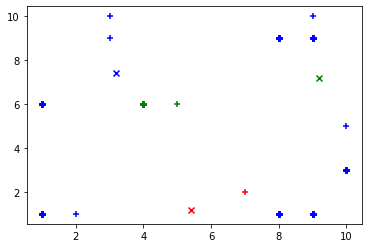

curMeans
[array([5.4, 1.2]), array([3.2, 7.4]), array([9.2, 7.2])]
curClusters
[[(7, 2)], [(1, 1), (1, 6), (2, 1), (3, 9), (3, 10), (8, 1), (8, 9), (9, 1), (9, 9), (9, 10), (10, 3), (10, 5)], [(4, 6), (5, 6)]]

2nd call to k_means
====== BEGIN K_M STEP ======
clusters: Counter({0: 5, 1: 5, 2: 5})
---
{(1, 1): 0, (1, 6): 1, (2, 1): 0, (3, 9): 1, (3, 10): 1, (4, 6): 1, (5, 6): 1, (7, 2): 0, (8, 1): 0, (8, 9): 2, (9, 1): 0, (9, 9): 2, (9, 10): 2, (10, 3): 2, (10, 5): 2}


---------------
covMatricies
covar matrix 0
[[13.3  0.4]
 [ 0.4  0.2]]
covar matrix 1
[[ 2.2  -0.35]
 [-0.35  3.8 ]]
covar matrix 2
[[ 0.7  -2.05]
 [-2.05  9.2 ]]
---------------
inverse COV matrices
0
[[-0.08  0.16]
 [ 0.16 -5.32]]
0
1
[[-0.46130501 -0.04248862]
 [-0.04248862 -0.26707132]]
1
2
[[-4.11173184 -0.91620112]
 [-0.91620112 -0.31284916]]
2
---------------
Cluster Means

Cluster 0
Points [(1, 1), (2, 1), (7, 2), (8, 1), (9, 1)]
XY Mean [5.4 1.2]

Cluster 1
Points [(1, 6), (3, 9), (3, 10), (4, 6), (5, 6)]
XY Mea

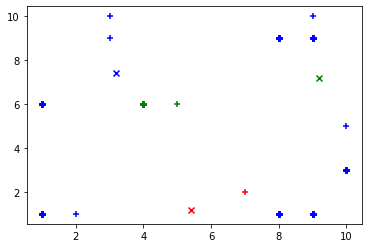

====== END K_M STEPPING ======
curMeans
[array([5.4, 1.2]), array([3.2, 7.4]), array([9.2, 7.2])]
curClusters
[[(7, 2)], [(1, 1), (1, 6), (2, 1), (3, 9), (3, 10), (8, 1), (8, 9), (9, 1), (9, 9), (9, 10), (10, 3), (10, 5)], [(4, 6), (5, 6)]]


([array([5.4, 1.2]), array([3.2, 7.4]), array([9.2, 7.2])],
 (((7, 2),),
  ((1, 1),
   (1, 6),
   (2, 1),
   (3, 9),
   (3, 10),
   (8, 1),
   (8, 9),
   (9, 1),
   (9, 9),
   (9, 10),
   (10, 3),
   (10, 5)),
  ((4, 6), (5, 6))))

In [362]:
print(initMeans)
k_means_segment(np.array(dataFromStrNoClass),
                k=3,
                initial_means=initMeans,
                DEBUG=True
)